# Modeling 111001011 all features

In this notebook, we're specifically working on the dataset formed by dropping (31, 496, 524, 917, 1183, 1299) with all features.

In [1]:
import itertools
import numpy as np
import pandas as pd
import scipy
from scipy import optimize

pd.set_option('display.precision',20)
pd.set_option('display.max_colwidth',100)

from sklearn import linear_model, svm, tree
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, cross_val_score, \
                                    GridSearchCV, RandomizedSearchCV, ShuffleSplit
from sklearn.neural_network import MLPRegressor
    
    
    
import xgboost as xgb

from time import time
from scipy.stats import randint as sp_randint

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from matplotlib import pyplot
rcParams['figure.figsize'] = 12, 4
%matplotlib inline

In [2]:
# def to compare goodness of fit on training set
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [3]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [4]:
# run randomized search
def random_search(regr, param_dist, n_iter_search): 
    rs = RandomizedSearchCV(regr, param_distributions=param_dist, scoring = 'neg_mean_squared_error',
                                   n_jobs=-1, n_iter=n_iter_search, cv=kfold) #, verbose = 4)
    start = time()
    rs.fit(x_train, y_train)
    print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
    report(rs.cv_results_)

In [5]:
# run single parameter search (for ridge or lasso)
def single_search(regr, params):
    regr_results_df = pd.DataFrame(dtype = 'float64')
    count = 0
    for k, v in params.items():
        for val in v:
            regr.set_params(**{k: val})
            regr_results_df.loc[count, k] = val
            results = cross_val_score(regr, x_train, y_train, cv=kfold, scoring = 'neg_mean_squared_error')
            (regr_results_df.loc[count, 'RMSE'], regr_results_df.loc[count, 'std dev']) = \
                    (np.sqrt(-results.mean()), np.sqrt(results.std()))
            count += 1
    return regr_results_df

In [6]:
# test against validation set
def validate(regr):
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_validation)
    return rmse(y_validation, y_pred)

In [7]:
# Cross-validation sets
kfold = KFold(n_splits=10, random_state=7)

In [8]:
df = pd.read_csv("./input/train_tidy_111001011.csv")

In [9]:
ss = ShuffleSplit(n_splits=1, test_size=0.20, random_state=71)

X = df.values

for train_idx, validation_idx in ss.split(X):
    train_df = df.iloc[train_idx]
    validation_df = df.iloc[validation_idx]
    
y_validation = validation_df['SalePrice'].values
x_validation = validation_df.drop(['HouseId', 'SalePrice', 'GarageAge', 'GarageAgeLin'],axis=1).values
y_train = train_df['SalePrice'].values
x_train = train_df.drop(['HouseId', 'SalePrice', 'GarageAge', 'GarageAgeLin'],axis=1).values

## Ridge regression

In [10]:
ridge_regr = linear_model.Ridge()

In [11]:
ridge_param = {'alpha': scipy.stats.expon(scale=10)}
random_search(ridge_regr, ridge_param, 20)

RandomizedSearchCV took 2.07 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 10.734490580733652}

Model with rank: 2
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 8.5699867605278239}

Model with rank: 3
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 7.8626801241357569}



alpha                    RMSE                 std dev
0     1.0  0.11487178277813338279  0.06419544229461715545
1     2.0  0.11296992013784562525  0.06399755926899612646
2     3.0  0.11197644235991319195  0.06377843246580387759
3     4.0  0.11135128770368829532  0.06360887387690317141
4     5.0  0.11093310923731056206  0.06347973264869662124
5     6.0  0.11064837271350175252  0.06337997889795141115
6     7.0  0.11045656586597370208  0.06330160887543456738
13   14.0  0.11037167428247253442  0.06303420652307138716
7     8.0  0.11033283755951237004  0.06323903754987730830
12   13.0  0.11030518279829230888  0.06305658265464419987
8     9.0  0.11026083190713702187  0.06318831072386828229
11   12.0  0.11025672376587790369  0.06308210094552224589
10   11.0  0.11022987148517367217  0.06311169267744433375
9    10.0  0.11022922574093965697  0.06314656683368080614

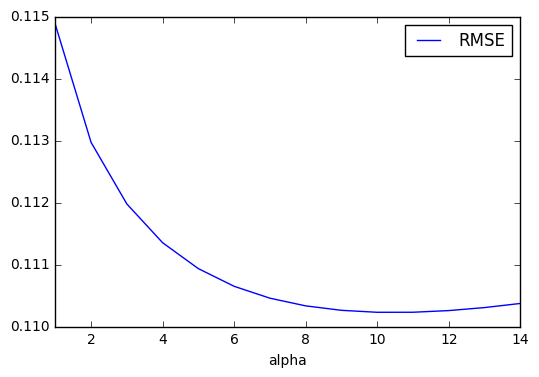

In [12]:
ridge_params = {'alpha': np.arange(1, 15, 1).tolist()}
ridge_df = single_search(ridge_regr, ridge_params)
ridge_df.plot(x = ['alpha'], y = ['RMSE'])
ridge_df.sort_values(['RMSE'], ascending = False)

In [13]:
ridge_regr = linear_model.Ridge(alpha = 10)

In [14]:
validate(ridge_regr)

0.11070767131297345

## Lasso

In [15]:
lasso_regr = linear_model.Lasso(max_iter=50000)

In [16]:
lasso_param = {'alpha': scipy.stats.expon(scale=0.001)}
random_search(lasso_regr, lasso_param, 20)

RandomizedSearchCV took 13.02 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 0.00036090982639673161}

Model with rank: 2
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 0.00024997376728718899}

Model with rank: 3
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 0.0004774810109535069}



alpha                    RMSE                 std dev
0  0.00010000000000000000  0.11292048167084432764  0.06469688045902929896
5  0.00060000000000000006  0.10957697327688518951  0.06427992343409458242
1  0.00020000000000000001  0.10936500887868474963  0.06411450677411925647
4  0.00050000000000000001  0.10893925781418142829  0.06382907512092957092
2  0.00030000000000000003  0.10850276722291493647  0.06360004570921831690
3  0.00040000000000000002  0.10848773100935661662  0.06354252022693683555

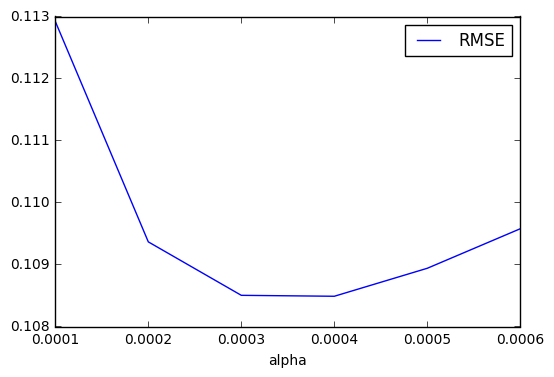

In [17]:
lasso_params = {'alpha': np.arange(0.0001, 0.0007, 0.0001).tolist()}
lasso_df = single_search(lasso_regr, lasso_params)
lasso_df.plot(x = ['alpha'], y = ['RMSE'])
lasso_df.sort_values(['RMSE'], ascending = False)

In [18]:
lasso_regr = linear_model.Lasso(alpha=0.0004, max_iter=50000)

In [19]:
validate(lasso_regr)

0.10654034924600239

## Lasso LARS

In [20]:
lassolars_regr = linear_model.LassoLars(max_iter=50000)

In [21]:
lassolars_param = {'alpha': scipy.stats.expon(scale=0.0001)}
random_search(lassolars_regr, lassolars_param, 20)

/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 204 iterations, i.e. alpha=3.161e-05, with an active set of 178 regressors, and the smallest cholesky pivot element being 2.356e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 184 iterations, i.e. alpha=4.305e-05, with an active set of 152 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 254 iterations, i.e. alpha=1.750e-05, with an active set of 204 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model

RandomizedSearchCV took 5.09 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 0.00012590038466059507}

Model with rank: 2
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 0.00010663943076723789}

Model with rank: 3
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 0.00015026682849930646}



/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 102 iterations, i.e. alpha=1.322e-04, with an active set of 94 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)


alpha                    RMSE                 std dev
0  0.00008000000000000001  0.10811574469798206077  0.06332949688360882401
7  0.00015000000000000001  0.10790846429220045388  0.06287254450375209802
1  0.00009000000000000001  0.10790804888169054643  0.06322374081562476267
6  0.00013999999999999999  0.10779102257076322857  0.06284256013760911030
2  0.00010000000000000000  0.10777806776496469399  0.06313215056319734786
5  0.00013000000000000002  0.10771081357084753838  0.06289498593757775202
3  0.00011000000000000000  0.10769088978633437059  0.06309385597049677052
4  0.00012000000000000000  0.10767079856644264091  0.06301867236963812346

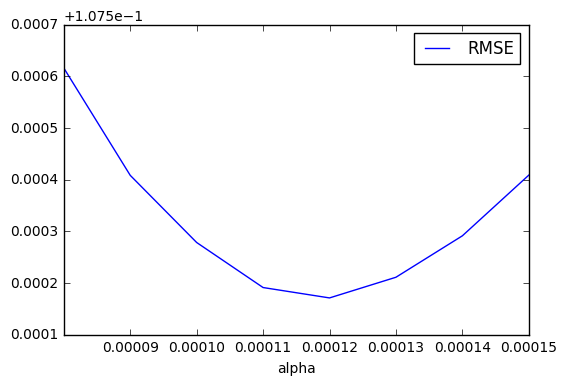

In [22]:
lassolars_params = {'alpha': np.arange(0.00008, 0.00016, 0.00001).tolist()}
lassolars_df = single_search(lassolars_regr, lassolars_params)
lassolars_df.plot(x = ['alpha'], y = ['RMSE'])
lassolars_df.sort_values(['RMSE'], ascending = False)

In [23]:
lassolars_regr = linear_model.LassoLars(alpha=0.00012, max_iter=50000)

In [24]:
validate(lassolars_regr)

0.10140943221676643

## Elastic Net

In [25]:
elnet_regr = linear_model.ElasticNet(max_iter=15000, random_state=7)

In [26]:
elnet_param =  {'alpha': scipy.stats.expon(scale=0.001), 'l1_ratio': scipy.stats.truncnorm(0, 1, loc=0.5, scale=0.25)}
random_search(elnet_regr, elnet_param, 20)

RandomizedSearchCV took 15.06 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 0.00049276160535701265, 'l1_ratio': 0.6006487557074105}

Model with rank: 2
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 0.00048750270482886016, 'l1_ratio': 0.51987011043391851}

Model with rank: 3
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 0.00072408412841512484, 'l1_ratio': 0.62825120408559998}



alpha                    RMSE                 std dev
0  0.00010000000000000000  0.11439436255552536126  0.06463347900018498460
1  0.00020000000000000001  0.11071777522780926195  0.06456383387170529231
2  0.00030000000000000003  0.10920166342922836555  0.06396889966840502151
6  0.00070000000000000010  0.10918647957381510949  0.06357195274330260104
5  0.00060000000000000006  0.10892878899329583309  0.06337135879192339061
3  0.00040000000000000002  0.10877379838307811577  0.06349045783093226758
4  0.00050000000000000001  0.10877227837381228670  0.06335299923733397898

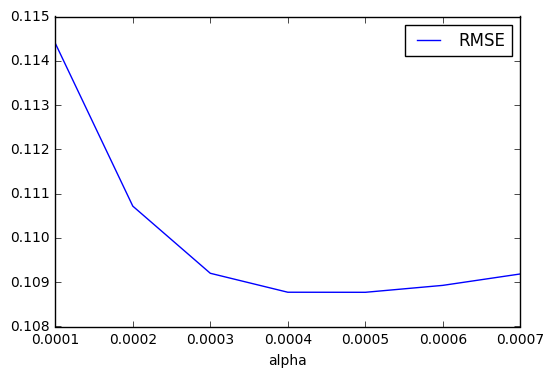

In [27]:
elnet_regr = linear_model.ElasticNet(alpha=0.00038, l1_ratio=0.72, max_iter=15000, random_state=7)
elnet_params = {'alpha': np.arange(0.0001, 0.0008, 0.0001).tolist()}
elnet_df = single_search(elnet_regr, elnet_params)
elnet_df.plot(x = ['alpha'], y = ['RMSE'])
elnet_df.sort_values(['RMSE'], ascending = False)

l1_ratio                    RMSE                 std dev
0  0.20000000000000001110  0.11154190478553527299  0.06434098786977245077
1  0.30000000000000004441  0.11026091132375652470  0.06418733264634729485
2  0.40000000000000007772  0.10944607811374344741  0.06390893974175648751
3  0.50000000000000011102  0.10905951427556032085  0.06351675710529311458
8  1.00000000000000022204  0.10893925781418141441  0.06382907512092962643
4  0.60000000000000008882  0.10886026609762639028  0.06332790187320808117
7  0.90000000000000013323  0.10879615098662479000  0.06356705966643402816
6  0.80000000000000026645  0.10878733800464845949  0.06342248206027251145
5  0.70000000000000017764  0.10878161528775050215  0.06334439592803858821

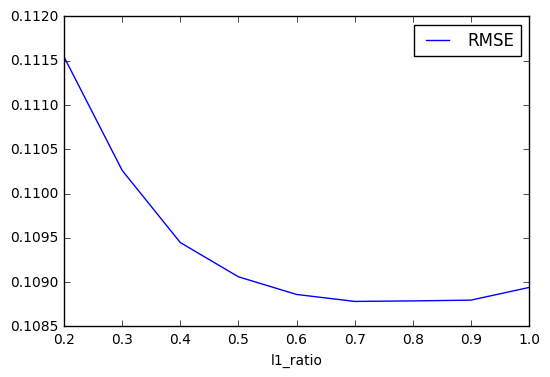

In [28]:
elnet_regr = linear_model.ElasticNet(alpha=0.0005, max_iter=15000, random_state=7)
elnet_params = {'l1_ratio': np.arange(0.2, 1.1, 0.1).tolist()}
elnet_df = single_search(elnet_regr, elnet_params)
elnet_df.plot(x = ['l1_ratio'], y = ['RMSE'])
elnet_df.sort_values(['RMSE'], ascending = False)

In [29]:
elnet_regr = linear_model.ElasticNet(alpha=0.0005, l1_ratio=0.7, max_iter=15000, random_state=7)

In [30]:
validate(elnet_regr)

0.10651801673667984

## Random Forest

In [31]:
rf_regr = RandomForestRegressor(n_jobs=-1, random_state = 7)

In [32]:
rf_param =  {'n_estimators': scipy.stats.randint(50,400), 'max_depth': scipy.stats.randint(2,20), 
             'max_features': scipy.stats.randint(5,30)}
random_search(rf_regr, rf_param, 20)

RandomizedSearchCV took 103.08 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.015 (std: 0.004)
Parameters: {'max_features': 28, 'n_estimators': 231, 'max_depth': 18}

Model with rank: 2
Mean validation score: -0.016 (std: 0.004)
Parameters: {'max_features': 28, 'n_estimators': 260, 'max_depth': 16}

Model with rank: 3
Mean validation score: -0.016 (std: 0.004)
Parameters: {'max_features': 17, 'n_estimators': 356, 'max_depth': 14}



n_estimators                    RMSE                 std dev
0          50.0  0.12467540709477997751  0.05851852093621669193
1         100.0  0.12311825877081210290  0.05964832714816022119
5         300.0  0.12310446701563276806  0.06159969263701042808
6         350.0  0.12310272991872116266  0.06177197883930793387
2         150.0  0.12309674540231349549  0.06166316067650285532
4         250.0  0.12297527685409198606  0.06166928830862057620
3         200.0  0.12292815450507603436  0.06144395997440445928
8         450.0  0.12290385411504987923  0.06181771655732232196
7         400.0  0.12288849362140626120  0.06172280848786605018
9         500.0  0.12288438492345175879  0.06159940572197337288

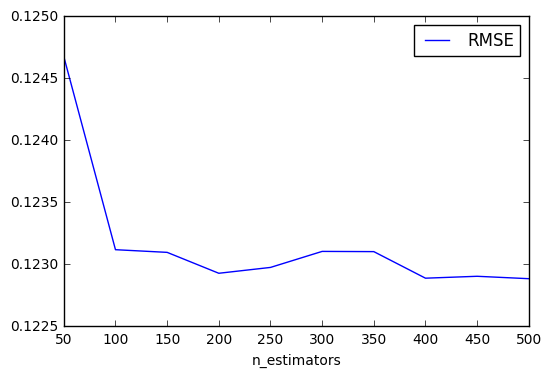

In [40]:
rf_regr = RandomForestRegressor(n_estimators = 231, max_depth = 13, max_features = 74, random_state = 7)
rf_params = {'n_estimators': np.arange(50, 550, 50).tolist()}
rf_df = single_search(rf_regr, rf_params)
rf_df.plot(x = ['n_estimators'], y = ['RMSE'])
rf_df.sort_values(['RMSE'], ascending = False)

In [41]:
rf_regr = RandomForestRegressor(n_estimators = 400, max_depth = 13, max_features = 74, random_state = 7)

In [42]:
validate(rf_regr)

0.12760073245486442

## Support Vector Regressor

In [33]:
svr_regr = svm.SVR(cache_size=200, degree=3, max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [34]:
svr_param = {'C': scipy.stats.expon(scale=1), 'gamma': scipy.stats.expon(scale=.1),
              'kernel': ['rbf']}
random_search(svr_regr, svr_param, 20)

RandomizedSearchCV took 45.15 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.014 (std: 0.004)
Parameters: {'kernel': 'rbf', 'C': 1.7242948769531929, 'gamma': 0.010725888871488835}

Model with rank: 2
Mean validation score: -0.016 (std: 0.004)
Parameters: {'kernel': 'rbf', 'C': 3.7260190161769615, 'gamma': 0.021647243303209489}

Model with rank: 3
Mean validation score: -0.016 (std: 0.004)
Parameters: {'kernel': 'rbf', 'C': 1.5662690611354544, 'gamma': 0.026897951893977506}



C                    RMSE                 std dev
10  3.00000000000000088818  0.11443419000568749722  0.06310370006003943044
9   2.90000000000000079936  0.11438069049188590021  0.06313992760106265645
8   2.80000000000000071054  0.11436770410753142879  0.06315389032462903618
7   2.70000000000000062172  0.11433488789233910154  0.06317671227462998140
6   2.60000000000000053291  0.11432375132781275040  0.06320185108520116890
5   2.50000000000000044409  0.11430271423330834457  0.06322473917124192544
4   2.40000000000000035527  0.11428299676597733492  0.06323324126326811123
0   2.00000000000000000000  0.11425913705366516626  0.06320571297045735060
2   2.20000000000000017764  0.11425849130122045505  0.06326918623201374658
1   2.10000000000000008882  0.11425326888846185081  0.06325325038048244808
3   2.30000000000000026645  0.11425219818037701813  0.06322655288446851762

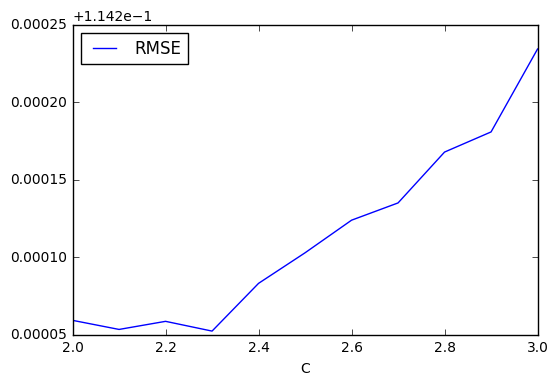

In [45]:
svr_regr = svm.SVR(C=1.7, cache_size=200, coef0=0.0, degree=3, gamma=0.006,
                        kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
svr_params = {'C': np.arange(2, 3.1, 0.1).tolist()}
svr_df = single_search(svr_regr, svr_params)
svr_df.plot(x = ['C'], y = ['RMSE'])
svr_df.sort_values(['RMSE'], ascending = False)

In [46]:
svr_regr = svm.SVR(C=2.3, cache_size=200, coef0=0.0, degree=3, gamma=0.006,
                        kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [47]:
validate(svr_regr)

0.11757030209723707

## Orthogonal Matching Pursuit

In [48]:
omp_regr = linear_model.OrthogonalMatchingPursuit()

In [49]:
omp_param = {'n_nonzero_coefs': scipy.stats.randint(20,120)}
random_search(omp_regr, omp_param, 20)

RandomizedSearchCV took 2.37 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.014 (std: 0.004)
Parameters: {'n_nonzero_coefs': 30}

Model with rank: 2
Mean validation score: -0.014 (std: 0.003)
Parameters: {'n_nonzero_coefs': 82}

Model with rank: 3
Mean validation score: -0.014 (std: 0.003)
Parameters: {'n_nonzero_coefs': 80}



n_nonzero_coefs                    RMSE                 std dev
4             34.0  0.11658215134047698880  0.06153416463231714539
0             30.0  0.11655486736409126358  0.05920659549388343490
3             33.0  0.11652141198605014960  0.06116217540506670852
1             31.0  0.11652120049717605565  0.05998344213807380726
2             32.0  0.11646051068352455959  0.06003736741172261554
9             39.0  0.11636403167297010297  0.06171304550364219849
6             36.0  0.11622125481533941704  0.06097575436831970813
5             35.0  0.11610493056847584481  0.06137942299604563084
8             38.0  0.11595077018635203958  0.05984155571183991801
7             37.0  0.11570099794765252577  0.06039462543998864313

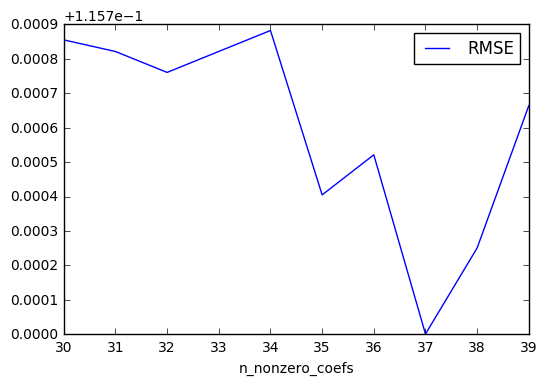

In [51]:
omp_regr = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=99)
omp_params = {'n_nonzero_coefs': np.arange(30, 40, 1).tolist()}
omp_df = single_search(omp_regr, omp_params)
omp_df.plot(x = ['n_nonzero_coefs'], y = ['RMSE'])
omp_df.sort_values(['RMSE'], ascending = False)

In [52]:
omp_regr = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=37)

In [53]:
validate(omp_regr)

0.10804868309577011

## XGBoost

In [54]:
xgb_regr = xgb.XGBRegressor(seed = 42, nthread = -1, silent = 1)
xgb_param = {'max_depth': scipy.stats.randint(1,10), # Max. Depth [1,∞]
             'min_child_weight': scipy.stats.expon(scale=1), # Min. Child Weight [0,∞]
             'gamma': scipy.stats.expon(scale=1), # Minimum Split Loss, gamma [0,∞]
             'subsample': scipy.stats.uniform(0, 1), # Subsample Ratio of the training instance [0,1]
             'colsample_bytree': scipy.stats.uniform(0, 1), # Subsample Ratio of columns [0,1]
             'reg_alpha': scipy.stats.expon(scale=1), # L1 regularization, alpha [0,∞]
             'reg_lambda': scipy.stats.expon(scale=1), # L2 regularization, lambda [0,∞]
             'learning_rate': scipy.stats.uniform(0, 1), # Step size shrinkage (learning rate) [0,1]
             'n_estimators': scipy.stats.randint(50,500) # Number of boosted trees, n_estimators
            }
random_search(xgb_regr, xgb_param, 20)

RandomizedSearchCV took 3412.37 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.018 (std: 0.004)
Parameters: {'reg_alpha': 0.12328977007727669, 'colsample_bytree': 0.32109341427137283, 'learning_rate': 0.48456045930381941, 'min_child_weight': 1.4875630659024288, 'n_estimators': 432, 'subsample': 0.63353077700590399, 'reg_lambda': 0.2011248068753993, 'max_depth': 2, 'gamma': 0.15099157333839039}

Model with rank: 2
Mean validation score: -0.019 (std: 0.004)
Parameters: {'reg_alpha': 0.08684077459792594, 'colsample_bytree': 0.30841701822257273, 'learning_rate': 0.21739683848562785, 'min_child_weight': 0.50670779492425955, 'n_estimators': 99, 'subsample': 0.35790848825006161, 'reg_lambda': 0.94654945394567702, 'max_depth': 2, 'gamma': 0.35220769897501886}

Model with rank: 3
Mean validation score: -0.020 (std: 0.004)
Parameters: {'reg_alpha': 1.195497099067832, 'colsample_bytree': 0.6430833513541474, 'learning_rate': 0.17870449004413336, 'min_chi

n_estimators                    RMSE                 std dev
8         1100.0  0.12162504417318625860  0.06520099393187064885
11        1250.0  0.12155014077761112923  0.06457977013304452840
9         1150.0  0.12153654074173401989  0.06505058750260539480
10        1200.0  0.12149053594894534958  0.06467071805801351270
13        1350.0  0.12147702829465240049  0.06499572235817728527
14        1400.0  0.12146370268667913694  0.06522921718406395064
12        1300.0  0.12138181665483220584  0.06455177848091096793
15        1450.0  0.12133123083059633995  0.06501025059664398975
5          950.0  0.12123645029688753794  0.06379643195718223692
6         1000.0  0.12122256992943766796  0.06388576200799221672
4          900.0  0.12121448171486151613  0.06352424220087675433
19        1650.0  0.12121009725852041616  0.06541088903646437303
20        1700.0  0.12118048064798436769  0.06527099108696264584
21        1750.0  0.12111747770360219156  0.06512102530341666584
7         1050.0  0.12111438765014383157  0.06398541631152053488
17        1550.0  0.12110850607612151653  0.06540327425272546291
16        1500.0  0.12106951391653812677  0.06509513386792289968
18        1600.0  0.12100246951793915129  0.06571950498438727806
3          850.0  0.12092693199569676255  0.06382452924485940149
2          800.0  0.12070309356090878905  0.06355243515522188136
1          750.0  0.12039878804467384066  0.06414684327658508323
0          700.0  0.12011617132372907901  0.06318883575318183510

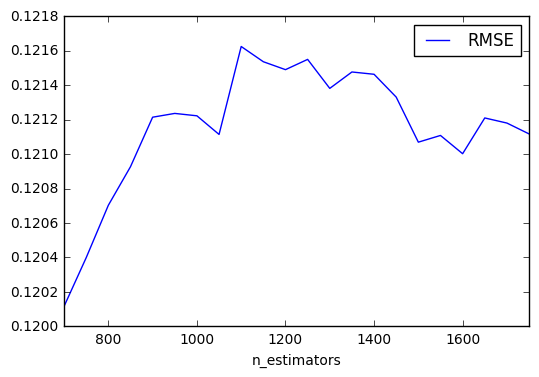

In [77]:
xgb_regr = xgb.XGBRegressor(
    max_depth = 1, 
    min_child_weight = 4.6,
    gamma = 0.03,
    subsample = 0.8,
    colsample_bytree = 0.88,
    reg_alpha = 0.8,
    reg_lambda = 0.2, 
    learning_rate = 0.9,
    n_estimators = 432,
    objective='reg:linear', 
    seed = 42,
    nthread = -1,
    silent = 1)
xgb_params = {'n_estimators': np.arange(700, 1800, 50).tolist()}
xgb_df = single_search(xgb_regr, xgb_params)
xgb_df.plot(x = ['n_estimators'], y = ['RMSE'])
xgb_df.sort_values(['RMSE'], ascending = False)

In [78]:
xgb_regr = xgb.XGBRegressor(
    max_depth = 1, 
    min_child_weight = 4.6,
    gamma = 0.03,
    subsample = 0.8,
    colsample_bytree = 0.88,
    reg_alpha = 0.8,
    reg_lambda = 0.2, 
    learning_rate = 0.9,
    n_estimators = 700,
    objective='reg:linear', 
    seed = 42,
    nthread = -1,
    silent = 1)

In [79]:
validate(xgb_regr)

0.12566475679191697

## MLP Regressor

In [56]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641,
                        hidden_layer_sizes=(100, ),
                        alpha=0.0001, 
                        tol=0.0001, 
                        max_iter=200)

In [57]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641)
mlp_param = {'hidden_layer_sizes': scipy.stats.randint(50,500), # size of a single hidden layer
             'alpha': scipy.stats.expon(scale=0.0001), # L2 regularization,  [0,∞]
             'tol': scipy.stats.expon(scale=0.0001), # Minimum improvement in loss fun. during training
             'max_iter': scipy.stats.uniform(200, 400), # Maximum number of iterations of solver
            }
random_search(mlp_regr, mlp_param, 20)

RandomizedSearchCV took 979.66 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.020 (std: 0.004)
Parameters: {'alpha': 1.172362590817122e-05, 'max_iter': 533.55721009284525, 'tol': 0.00032739582860585371, 'hidden_layer_sizes': 239}

Model with rank: 2
Mean validation score: -0.020 (std: 0.003)
Parameters: {'alpha': 9.2545203265638468e-05, 'max_iter': 381.98633798220499, 'tol': 5.5907177934508414e-05, 'hidden_layer_sizes': 352}

Model with rank: 3
Mean validation score: -0.020 (std: 0.003)
Parameters: {'alpha': 0.00018503929135201826, 'max_iter': 586.90367395728094, 'tol': 8.9125678784467231e-05, 'hidden_layer_sizes': 352}



max_iter                    RMSE                 std dev
0      50.0  0.16120121301785592105  0.07990532248503823265
1     100.0  0.13346488970514361339  0.06383133451440975437
2     150.0  0.12658968851707463887  0.06176493239610168079
3     200.0  0.12452474166113446097  0.06267693169375800066
4     250.0  0.12197982209282913491  0.06122786130988728398
5     300.0  0.11951798019862575062  0.06085410369432001088
7     400.0  0.11897687377589538649  0.06320379669691585101
8     450.0  0.11876065205545967285  0.06177148589359809233
6     350.0  0.11835450108453475504  0.06250802151797234252

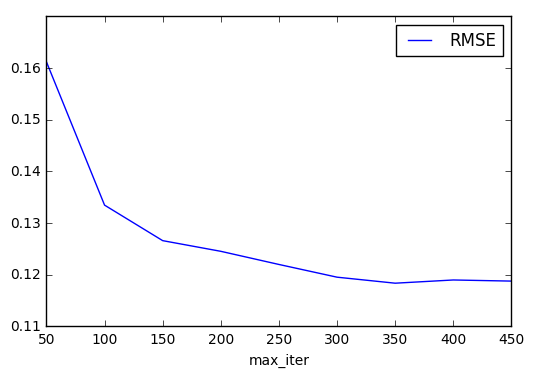

In [71]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641,
                        hidden_layer_sizes=(3, ),
                        alpha=0.000009, 
                        tol=0.0003, 
                        max_iter=530)
mlp_params = {'max_iter': np.arange(50, 500, 50).tolist()}
mlp_df = single_search(mlp_regr, mlp_params)
mlp_df.plot(x = ['max_iter'], y = ['RMSE'])
mlp_df.sort_values(['RMSE'], ascending = False)

In [73]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641,
                        hidden_layer_sizes=(3, ),
                        alpha=0.000009, 
                        tol=0.0003, 
                        max_iter=350)

In [74]:
validate(mlp_regr)

0.12128540989238758